# Import package and data

In [1]:
# import the necessary libraries
import numpy as np 
import pandas as pd 
import os

# Visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pycountry
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot 
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
import chart_studio.plotly as py
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
#py.init_notebook_mode(connected=True)

#Geographical Plotting
import folium
from folium import Choropleth, Circle, Marker
from folium import plugins
from folium.plugins import HeatMap, MarkerCluster

#Racing Bar Chart
import bar_chart_race as bcr
from IPython.display import HTML

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = 8, 5
plt.style.use("fivethirtyeight")# for pretty graphs

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Disable warnings 
import warnings
warnings.filterwarnings('ignore')
city_day = pd.read_csv('city_day.csv')
#city_hour = pd.read_csv('city_hour.csv')
#station = pd.read_csv('stations.csv')
#station_day = pd.read_csv('station_day.csv')
#station_hour = pd.read_csv('station_hour.csv')
cities_db = pd.read_csv('Indian Cities Database.csv')

# A first look

In [2]:
display("CITY DAILY DATA")
display(city_day.head(5))
city_day.info()

'CITY DAILY DATA'

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB


There seems to be a lot of missing values in the dataset. Additionally, the Date column is also not in the Date-Time format.

Convert to Date Time format and Data Availability

In [3]:
# Convert string to datetime64
city_day['Date'] = pd.to_datetime(city_day['Date'])
print(f"The available data is between {city_day['Date'].min()} and {city_day['Date'].max()}")
city_day.head()

The available data is between 2015-01-01 00:00:00 and 2020-07-01 00:00:00


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [4]:
# Missing values
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

missing_values= missing_values_table(city_day)
missing_values.style.background_gradient(cmap='Greens')

Your selected dataframe has 16 columns.
There are 14 columns that have missing values.


,Missing Values,% of Total Values
Xylene,18109,61.300000
PM10,11140,37.700000
NH3,10328,35.000000
Toluene,8041,27.200000
Benzene,5623,19.000000
AQI,4681,15.900000
AQI_Bucket,4681,15.900000
PM2.5,4598,15.600000
NOx,4185,14.200000
O3,4022,13.600000


Cities in the dataset

In [5]:
cities = city_day['City'].value_counts()
print(f'Total number of cities in the dataset : {len(cities)}')
print(cities.index)

Total number of cities in the dataset : 26
Index(['Ahmedabad', 'Delhi', 'Mumbai', 'Bengaluru', 'Lucknow', 'Chennai',
       'Hyderabad', 'Patna', 'Gurugram', 'Visakhapatnam', 'Amritsar',
       'Jorapokhar', 'Jaipur', 'Thiruvananthapuram', 'Amaravati',
       'Brajrajnagar', 'Talcher', 'Kolkata', 'Guwahati', 'Coimbatore',
       'Shillong', 'Chandigarh', 'Bhopal', 'Ernakulam', 'Kochi', 'Aizawl'],
      dtype='object')


# Analysing the complete City Level Daily Data

Combining the Benzene, Toluene and Xylene levels into one column - BTX
Combining the PM2.5 and PM10 into one column
Subsetting columns

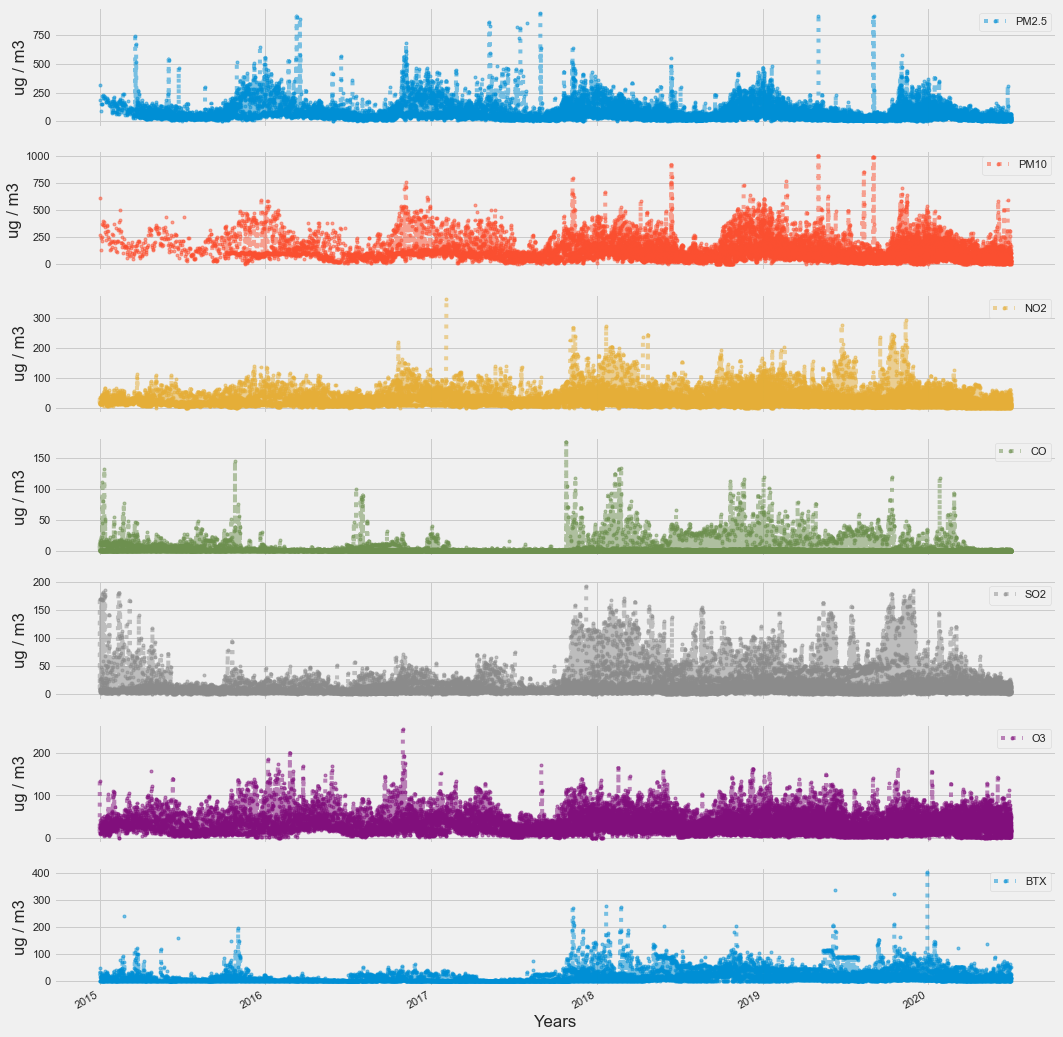

In [8]:
city_day['BTX'] = city_day['Benzene']+city_day['Toluene']+city_day['Xylene']
city_day.drop(['Benzene','Toluene','Xylene'],axis=1);
pollutants = ['PM2.5','PM10','NO2', 'CO', 'SO2','O3', 'BTX']
# city_day.set_index('Date',inplace=True)
cityday = city_day
cityday.index = cityday.Date
axes = cityday[pollutants].plot(marker='.', alpha=0.5, linestyle=':', figsize=(16, 20), subplots=True)
for ax in axes:
    ax.set_xlabel('Years')
    ax.set_ylabel('ug / m3')

PM2.5 and PM10 pollution show a seasonal effect, with pollution being higher in winter months as compared to the summer ones.
SO2 level has started increasing after 2017, although it had also seen a sudden rise in 2015 also. The same pattern is also reflected in BTX levels also.

# Effect of Lockdown on AQI

## AQI for some of the major cities of India

In [ ]:
cities = ['Ahmedabad','Delhi','Bengaluru','Mumbai','Hyderabad','Chennai']

filtered_city_day = city_day[city_day['Date'] >= '2019-01-01']
AQI = filtered_city_day[filtered_city_day.City.isin(cities)][['Date','City','AQI','AQI_Bucket']]
AQI.head()


,Date,City,AQI,AQI_Bucket
1461,2019-01-01,Ahmedabad,1474.0,Severe
1462,2019-01-02,Ahmedabad,1246.0,Severe
1463,2019-01-03,Ahmedabad,1719.0,Severe
1464,2019-01-04,Ahmedabad,1264.0,Severe
1465,2019-01-05,Ahmedabad,1127.0,Severe


In [ ]:
AQI_pivot = AQI.pivot(index='Date', columns='City', values='AQI')
AQI_pivot.fillna(method='bfill',inplace=True)


from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=6, cols=1,
    #specs=[[{}, {}],
          # [{"colspan": 6}, None]],
    subplot_titles=("Ahmedabad","Bengaluru","Chennai","Delhi",'Hyderabad','Mumbai'))

fig.add_trace(go.Bar(x=AQI_pivot.index, y=AQI_pivot['Ahmedabad'],
                    marker=dict(color=AQI_pivot['Ahmedabad'],coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x=AQI_pivot.index, y=AQI_pivot['Bengaluru'],
                    marker=dict(color=AQI_pivot['Bengaluru'], coloraxis="coloraxis")),
              2, 1)
fig.add_trace(go.Bar(x=AQI_pivot.index, y=AQI_pivot['Chennai'],
                    marker=dict(color=AQI_pivot['Chennai'], coloraxis="coloraxis")),
              3, 1)
fig.add_trace(go.Bar(x=AQI_pivot.index, y=AQI_pivot['Delhi'],
                    marker=dict(color=AQI_pivot['Delhi'], coloraxis="coloraxis")),
              4, 1)
fig.add_trace(go.Bar(x=AQI_pivot.index, y=AQI_pivot['Hyderabad'],
                    marker=dict(color=AQI_pivot['Hyderabad'], coloraxis="coloraxis")),
              5, 1)
fig.add_trace(go.Bar(x=AQI_pivot.index, y=AQI_pivot['Mumbai'],
                    marker=dict(color=AQI_pivot['Mumbai'], coloraxis="coloraxis")),
              6, 1)

fig.update_layout(coloraxis=dict(colorscale='rainbow'),showlegend=False,title_text="AQI Levels")

fig.update_layout(plot_bgcolor='#f6f5ec')

fig.update_layout( width=800,height=1200,shapes=[
      dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= '2020-03-25', x1= '2020-03-25'
    ),
      dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= '2020-06-07', x1= '2020-06-07'
    )
])

fig.show()

The black vertical line shows the date on which the first phase of lockdown ame into effect in India.
The above graph shows the variation of various pollutant levels, from Jan 2019 onwards till date.
Apparantely, all the above Indian cities seem to be a dangerously high level of pollution levels.
Clearly, there appears to be a rapid decline after 25th March,2020 in all the cities under sonsideration.

## AQI before and after Lockdown

In [ ]:
AQI_beforeLockdown = AQI_pivot['2020-01-01':'2020-03-25']
AQI_afterLockdown = AQI_pivot['2020-03-26':'2020-05-01']
print(AQI_beforeLockdown.mean())
print(AQI_afterLockdown.mean())

City
Ahmedabad    383.776471
Bengaluru     96.023529
Chennai       80.317647
Delhi        246.305882
Hyderabad     94.435294
Mumbai       148.776471
dtype: float64
City
Ahmedabad    127.810811
Bengaluru     68.486486
Chennai       62.351351
Delhi        107.270270
Hyderabad     65.567568
Mumbai        73.891892
dtype: float64


"Ahmedabad's AQI levels"

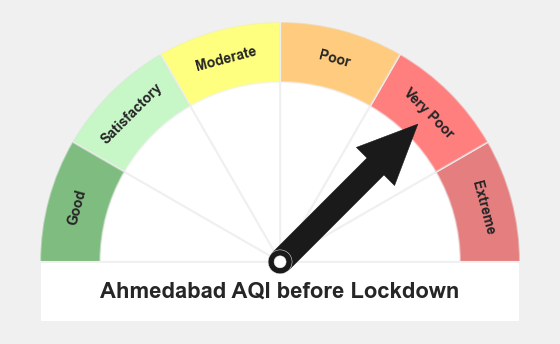

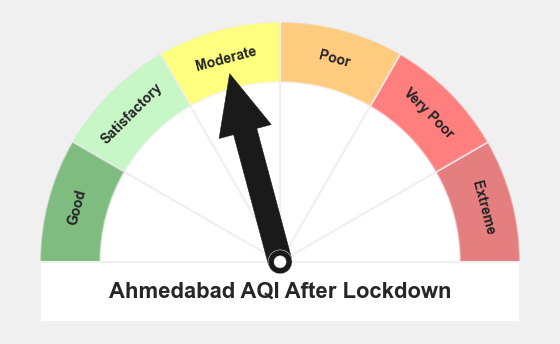

In [ ]:
# Helper functions

#source: http://nicolasfauchereau.github.io/climatecode/posts/drawing-a-gauge-with-matplotlib/
from matplotlib.patches import Circle, Wedge, Rectangle

def degree_range(n): 
    start = np.linspace(0,180,n+1, endpoint=True)[0:-1]
    end = np.linspace(0,180,n+1, endpoint=True)[1::]
    mid_points = start + ((end-start)/2.)
    return np.c_[start, end], mid_points

def rot_text(ang): 
    rotation = np.degrees(np.radians(ang) * np.pi / np.pi - np.radians(90))
    return rotation

from matplotlib.patches import Circle, Wedge, Rectangle
def gauge(labels=['GOOD','SATISFACTORY','MODERATE','POOR','VERY POOR','EXTREME'], \
          colors='jet_r', arrow=1, title='', fname=False): 
    
    """
    some sanity checks first
    

"""
    
    N = len(labels)
    
    if arrow > N: 
        raise Exception("\n\nThe category ({}) is greated than \
        the length\nof the labels ({})".format(arrow, N))
 
    
    """
    if colors is a string, we assume it's a matplotlib colormap
    and we discretize in N discrete colors 
    """
    
    if isinstance(colors, str):
        cmap = cm.get_cmap(colors, N)
        cmap = cmap(np.arange(N))
        colors = cmap[::-1,:].tolist()
    if isinstance(colors, list): 
        if len(colors) == N:
            colors = colors[::-1]
        else: 
            raise Exception("\n\nnumber of colors {} not equal \
            to number of categories{}\n".format(len(colors), N))

    """
    begins the plotting
    """
    
    fig, ax = plt.subplots()

    ang_range, mid_points = degree_range(N)

    labels = labels[::-1]
    
    """
    plots the sectors and the arcs
    """
    patches = []
    for ang, c in zip(ang_range, colors): 
        # sectors
        patches.append(Wedge((0.,0.), .4, *ang, facecolor='w', lw=2))
        # arcs
        patches.append(Wedge((0.,0.), .4, *ang, width=0.10, facecolor=c, lw=2, alpha=0.5))
    
    [ax.add_patch(p) for p in patches]

    
    """
    set the labels (e.g. 'LOW','MEDIUM',...)
    """

    for mid, lab in zip(mid_points, labels): 

        ax.text(0.35 * np.cos(np.radians(mid)), 0.35 * np.sin(np.radians(mid)), lab, \
            horizontalalignment='center', verticalalignment='center', fontsize=14, \
            fontweight='bold', rotation = rot_text(mid))

    """
    set the bottom banner and the title
    """
    r = Rectangle((-0.4,-0.1),0.8,0.1, facecolor='w', lw=2)
    ax.add_patch(r)
    
    ax.text(0, -0.05, title, horizontalalignment='center', \
         verticalalignment='center', fontsize=22, fontweight='bold')

    """
    plots the arrow now
    """
    
    pos = mid_points[abs(arrow - N)]
    
    ax.arrow(0, 0, 0.225 * np.cos(np.radians(pos)), 0.225 * np.sin(np.radians(pos)), \
                 width=0.04, head_width=0.09, head_length=0.1, fc='k', ec='k')
    
    ax.add_patch(Circle((0, 0), radius=0.02, facecolor='k'))
    ax.add_patch(Circle((0, 0), radius=0.01, facecolor='w', zorder=11))

    """
    removes frame and ticks, and makes axis equal and tight
    """
    
    ax.set_frame_on(False)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    ax.axis('equal')
    plt.tight_layout()
    if fname:
        fig.savefig(fname, dpi=200)
display("Ahmedabad's AQI levels")

gauge(labels=['Good','Satisfactory','Moderate','Poor','Very Poor','Extreme'], \
      colors=['#007A00','#90EE90','#ffff00','#FF9900','#ff0000','#CC0000'], arrow=5, title='Ahmedabad AQI before Lockdown') 

gauge(labels=['Good','Satisfactory','Moderate','Poor','Very Poor','Extreme'], \
      colors=['#007A00','#90EE90','#ffff00','#FF9900','#ff0000','#CC0000'], arrow=3, title='Ahmedabad AQI After Lockdown') 

"Delhi's AQI levels"

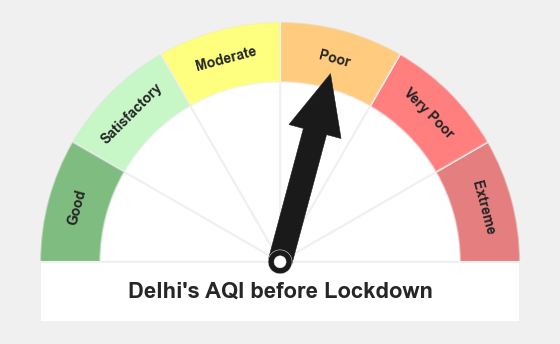

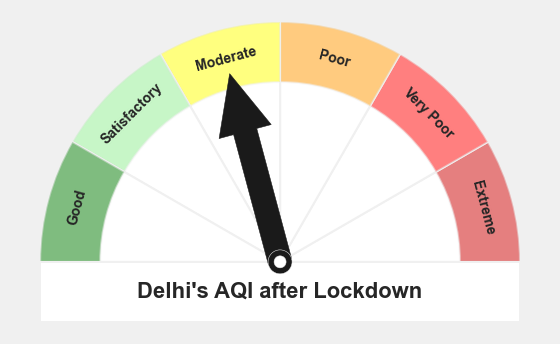

In [ ]:
display("Delhi's AQI levels")

gauge(labels=['Good','Satisfactory','Moderate','Poor','Very Poor','Extreme'], \
      colors=['#007A00','#90EE90','#ffff00','#FF9900','#ff0000','#CC0000'], arrow=4, title="Delhi's AQI before Lockdown") 

gauge(labels=['Good','Satisfactory','Moderate','Poor','Very Poor','Extreme'], \
      colors=['#007A00','#90EE90','#ffff00','#FF9900','#ff0000','#CC0000'], arrow=3, title="Delhi's AQI after Lockdown") 

"Mumbai's AQI levels"

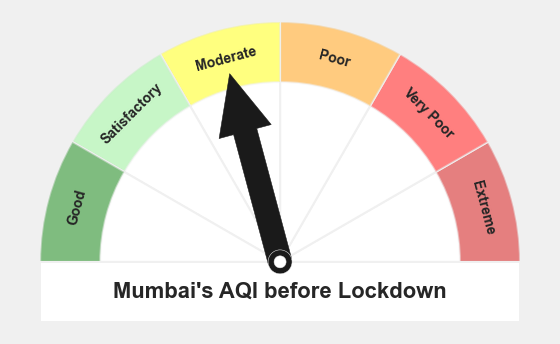

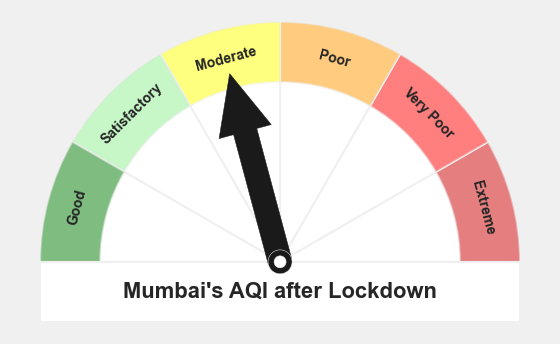

In [ ]:
display("Mumbai's AQI levels")

gauge(labels=['Good','Satisfactory','Moderate','Poor','Very Poor','Extreme'], \
      colors=['#007A00','#90EE90','#ffff00','#FF9900','#ff0000','#CC0000'], arrow=3, title="Mumbai's AQI before Lockdown") 

gauge(labels=['Good','Satisfactory','Moderate','Poor','Very Poor','Extreme'], \
      colors=['#007A00','#90EE90','#ffff00','#FF9900','#ff0000','#CC0000'], arrow=3, title="Mumbai's AQI after Lockdown") 